# Telecom X - Parte 2: Modelado Predictivo de Cancelacion de Clientes

**Objetivo**: Desarrollar modelos predictivos capaces de prever que clientes tienen mayor probabilidad de cancelar sus servicios.

---

# 1. Preparacion de los Datos

## 1.1 Carga del archivo tratado
Reproducimos la limpieza realizada en la Parte 1 para obtener el dataset listo para modelado.

In [ ]:
# Instalar dependencias necesarias
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn


[notice] A new release of pip is available: 24.0 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

# Cargar datos desde el JSON original
with open('TelecomX_Data.json', 'r', encoding='utf-8') as file:
    datos_json = json.load(file)

# Convertir a DataFrame
df = pd.json_normalize(datos_json)

# --- Reproducir limpieza de la Parte 1 ---

# Convertir cargo total a numerico (strings vacios/espacios se convierten en NaN)
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')
# IMPORTANTE: En Pandas 3.0, inplace=True no funciona con Copy-on-Write.
# Se debe usar asignacion directa.
df['account.Charges.Total'] = df['account.Charges.Total'].fillna(df['account.Charges.Total'].median())

# Crear cargo diario
df['Cuentas_Diarias'] = df['account.Charges.Monthly'] / 30

# Renombrar columnas al espanol
mapeo_columnas = {
    'customerID': 'id_cliente',
    'Churn': 'cancelacion',
    'customer.gender': 'genero',
    'customer.SeniorCitizen': 'es_adulto_mayor',
    'customer.Partner': 'tiene_pareja',
    'customer.Dependents': 'tiene_dependientes',
    'customer.tenure': 'meses_contrato',
    'phone.PhoneService': 'servicio_telefonico',
    'phone.MultipleLines': 'lineas_multiples',
    'internet.InternetService': 'servicio_internet',
    'internet.OnlineSecurity': 'seguridad_online',
    'internet.OnlineBackup': 'respaldo_online',
    'internet.DeviceProtection': 'proteccion_dispositivo',
    'internet.TechSupport': 'soporte_tecnico',
    'internet.StreamingTV': 'streaming_tv',
    'internet.StreamingMovies': 'streaming_peliculas',
    'account.Contract': 'tipo_contrato',
    'account.PaperlessBilling': 'factura_electronica',
    'account.PaymentMethod': 'metodo_pago',
    'account.Charges.Monthly': 'cargo_mensual',
    'account.Charges.Total': 'cargo_total',
    'Cuentas_Diarias': 'cargo_diario'
}
df = df.rename(columns=mapeo_columnas)

# Convertir Yes/No a 1/0
columnas_binarias = ['cancelacion', 'tiene_pareja', 'tiene_dependientes',
                     'servicio_telefonico', 'factura_electronica']
for col in columnas_binarias:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Eliminar filas donde cancelacion es NaN (224 registros con valor vacio)
print(f'Registros antes de eliminar NaN en cancelacion: {len(df)}')
df = df.dropna(subset=['cancelacion'])
df['cancelacion'] = df['cancelacion'].astype(int)
print(f'Registros despues de eliminar NaN: {len(df)}')

# Eliminar cualquier fila restante con NaN
df = df.dropna()
print(f'Registros finales (sin NaN): {len(df)}')

# Verificacion
print(f'\nNaN totales en el dataset: {df.isnull().sum().sum()}')
print(f'Dataset cargado: {df.shape[0]} filas x {df.shape[1]} columnas')
df.head()

Registros antes de eliminar NaN en cancelacion: 7267
Registros despues de eliminar NaN: 7043
Registros finales (sin NaN): 7043

NaN totales en el dataset: 0
Dataset cargado: 7043 filas x 22 columnas


,id_cliente,cancelacion,genero,es_adulto_mayor,tiene_pareja,tiene_dependientes,meses_contrato,servicio_telefonico,lineas_multiples,servicio_internet,...,proteccion_dispositivo,soporte_tecnico,streaming_tv,streaming_peliculas,tipo_contrato,factura_electronica,metodo_pago,cargo_mensual,cargo_total,cargo_diario
0,0002-ORFBO,0,Female,0,1,1,9,1,No,DSL,...,No,Yes,Yes,No,One year,1,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,0,Male,0,0,0,9,1,Yes,DSL,...,No,No,No,Yes,Month-to-month,0,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,1,Male,0,0,0,4,1,No,Fiber optic,...,Yes,No,No,No,Month-to-month,1,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,1,Male,1,1,0,13,1,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,1,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,1,Female,1,1,0,3,1,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,1,Mailed check,83.9,267.40,2.796667


## 1.2 Eliminacion de columnas irrelevantes
El `id_cliente` es un identificador unico que no aporta valor predictivo. Tambien eliminamos `cargo_diario` porque es derivacion directa de `cargo_mensual` (redundancia perfecta).

In [ ]:
# Eliminar columnas irrelevantes para el modelado
df_ml = df.drop(columns=['id_cliente', 'cargo_diario'])

print(f'Columnas restantes ({len(df_ml.columns)}):')
print(df_ml.columns.tolist())
print(f'\nDimensiones: {df_ml.shape}')

Columnas restantes (20):
['cancelacion', 'genero', 'es_adulto_mayor', 'tiene_pareja', 'tiene_dependientes', 'meses_contrato', 'servicio_telefonico', 'lineas_multiples', 'servicio_internet', 'seguridad_online', 'respaldo_online', 'proteccion_dispositivo', 'soporte_tecnico', 'streaming_tv', 'streaming_peliculas', 'tipo_contrato', 'factura_electronica', 'metodo_pago', 'cargo_mensual', 'cargo_total']

Dimensiones: (7043, 20)


## 1.3 Encoding de variables categoricas
Aplicamos **one-hot encoding** a las variables categoricas para hacerlas compatibles con los algoritmos de ML. Usamos `drop_first=True` para evitar la trampa de la multicolinealidad.

In [ ]:
# Identificar columnas categoricas
cols_categoricas = df_ml.select_dtypes(include=['object', 'string', 'str']).columns.tolist()
print(f'Variables categoricas a codificar ({len(cols_categoricas)}):')
for col in cols_categoricas:
    print(f'  {col}: {sorted(df_ml[col].unique())}')

# Aplicar one-hot encoding
df_encoded = pd.get_dummies(df_ml, columns=cols_categoricas, drop_first=True, dtype=int)

# Asegurar que todas las columnas sean numericas
for col in df_encoded.columns:
    df_encoded[col] = pd.to_numeric(df_encoded[col], errors='coerce')

# Eliminar cualquier NaN residual
df_encoded = df_encoded.dropna()

print(f'\nDimensiones despues del encoding: {df_encoded.shape}')
print(f'NaN restantes: {df_encoded.isnull().sum().sum()}')
print(f'\nColumnas resultantes:')
print(df_encoded.columns.tolist())

Variables categoricas a codificar (11):
  genero: ['Female', 'Male']
  lineas_multiples: ['No', 'No phone service', 'Yes']
  servicio_internet: ['DSL', 'Fiber optic', 'No']
  seguridad_online: ['No', 'No internet service', 'Yes']
  respaldo_online: ['No', 'No internet service', 'Yes']
  proteccion_dispositivo: ['No', 'No internet service', 'Yes']
  soporte_tecnico: ['No', 'No internet service', 'Yes']
  streaming_tv: ['No', 'No internet service', 'Yes']
  streaming_peliculas: ['No', 'No internet service', 'Yes']
  tipo_contrato: ['Month-to-month', 'One year', 'Two year']
  metodo_pago: ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']

Dimensiones despues del encoding: (7043, 31)
NaN restantes: 0

Columnas resultantes:
['cancelacion', 'es_adulto_mayor', 'tiene_pareja', 'tiene_dependientes', 'meses_contrato', 'servicio_telefonico', 'factura_electronica', 'cargo_mensual', 'cargo_total', 'genero_Male', 'lineas_multiples_No phone service', 'lineas

## 1.4 Verificacion de la proporcion de cancelacion (Churn)

PROPORCION DE CANCELACION
No cancelo (0): 5174 (73.5%)
Cancelo    (1): 1869 (26.5%)

Ratio desbalance: 2.77:1


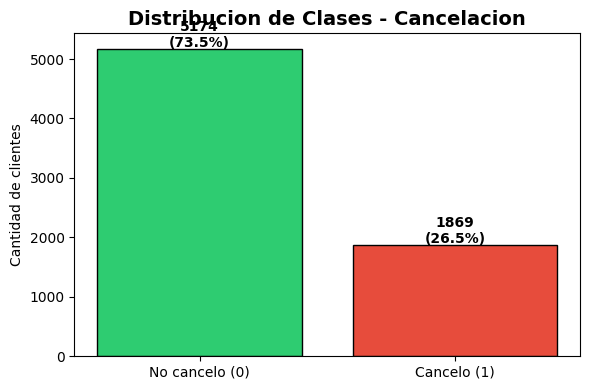


Existe un desbalance moderado entre las clases.
Aplicaremos SMOTE para balancear las clases durante el entrenamiento.


In [ ]:
# Proporcion de clases
conteo = df_encoded['cancelacion'].value_counts()
proporcion = df_encoded['cancelacion'].value_counts(normalize=True) * 100

print('PROPORCION DE CANCELACION')
print('=' * 40)
print(f'No cancelo (0): {conteo[0]} ({proporcion[0]:.1f}%)')
print(f'Cancelo    (1): {conteo[1]} ({proporcion[1]:.1f}%)')
print(f'\nRatio desbalance: {conteo[0]/conteo[1]:.2f}:1')

# Visualizacion
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(['No cancelo (0)', 'Cancelo (1)'], conteo.values,
              color=['#2ecc71', '#e74c3c'], edgecolor='black')
ax.set_title('Distribucion de Clases - Cancelacion', fontsize=14, fontweight='bold')
ax.set_ylabel('Cantidad de clientes')
for bar, val, pct in zip(bars, conteo.values, proporcion.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
            f'{val}\n({pct:.1f}%)', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

print('\nExiste un desbalance moderado entre las clases.')
print('Aplicaremos SMOTE para balancear las clases durante el entrenamiento.')

## 1.5 Balanceo de clases con SMOTE
El dataset presenta un desbalance de aproximadamente 73/27. Utilizamos **SMOTE** (Synthetic Minority Oversampling Technique) para generar ejemplos sinteticos de la clase minoritaria y equilibrar el entrenamiento.

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Separar features y target
X = df_encoded.drop(columns=['cancelacion']).astype(float)
y = df_encoded['cancelacion'].astype(int)

print(f'Datos: X={X.shape}, NaN={X.isnull().sum().sum()}')

# Division en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print(f'\nConjunto de entrenamiento: {len(X_train)} registros')
print(f'Conjunto de prueba: {len(X_test)} registros')

print('\nANTES del balanceo (conjunto de entrenamiento):')
print(y_train.value_counts())

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print(f'\nDESPUES del balanceo (conjunto de entrenamiento):')
print(pd.Series(y_train_bal).value_counts())

print(f'\nConjunto de prueba (sin modificar): {len(X_test)} registros')

Datos: X=(7043, 30), NaN=0

Conjunto de entrenamiento: 4930 registros
Conjunto de prueba: 2113 registros

ANTES del balanceo (conjunto de entrenamiento):
cancelacion
0    3622
1    1308
Name: count, dtype: int64

DESPUES del balanceo (conjunto de entrenamiento):
cancelacion
0    3622
1    3622
Name: count, dtype: int64

Conjunto de prueba (sin modificar): 2113 registros


## 1.6 Normalizacion de datos
Aplicamos **StandardScaler** para los modelos sensibles a la escala (Regresion Logistica). Los modelos basados en arboles (Random Forest) no requieren normalizacion, por lo que mantendremos ambas versiones de los datos.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Crear el escalador ajustado SOLO con datos de entrenamiento
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_bal),
    columns=X_train_bal.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

print('Datos normalizados (StandardScaler)')
print('\nEstadisticas del conjunto de entrenamiento escalado:')
print(X_train_scaled.describe().loc[['mean', 'std']].round(3))

print('\nNota: La media se aproxima a 0 y la desviacion estandar a 1.')
print('Estos datos escalados se usaran para Regresion Logistica.')
print('Random Forest usara los datos sin escalar (X_train_bal, X_test).')

Datos normalizados (StandardScaler)

Estadisticas del conjunto de entrenamiento escalado:
      es_adulto_mayor  tiene_pareja  tiene_dependientes  meses_contrato  \
mean              0.0          -0.0                 0.0            -0.0   
std               1.0           1.0                 1.0             1.0   

      servicio_telefonico  factura_electronica  cargo_mensual  cargo_total  \
mean                  0.0                  0.0            0.0          0.0   
std                   1.0                  1.0            1.0          1.0   

      genero_Male  lineas_multiples_No phone service  ...  \
mean         -0.0                                0.0  ...   
std           1.0                                1.0  ...   

      soporte_tecnico_Yes  streaming_tv_No internet service  streaming_tv_Yes  \
mean                  0.0                              -0.0              -0.0   
std                   1.0                               1.0               1.0   

      streaming_pelic

---
# 2. Correlacion y Seleccion de Variables

## 2.1 Matriz de correlacion

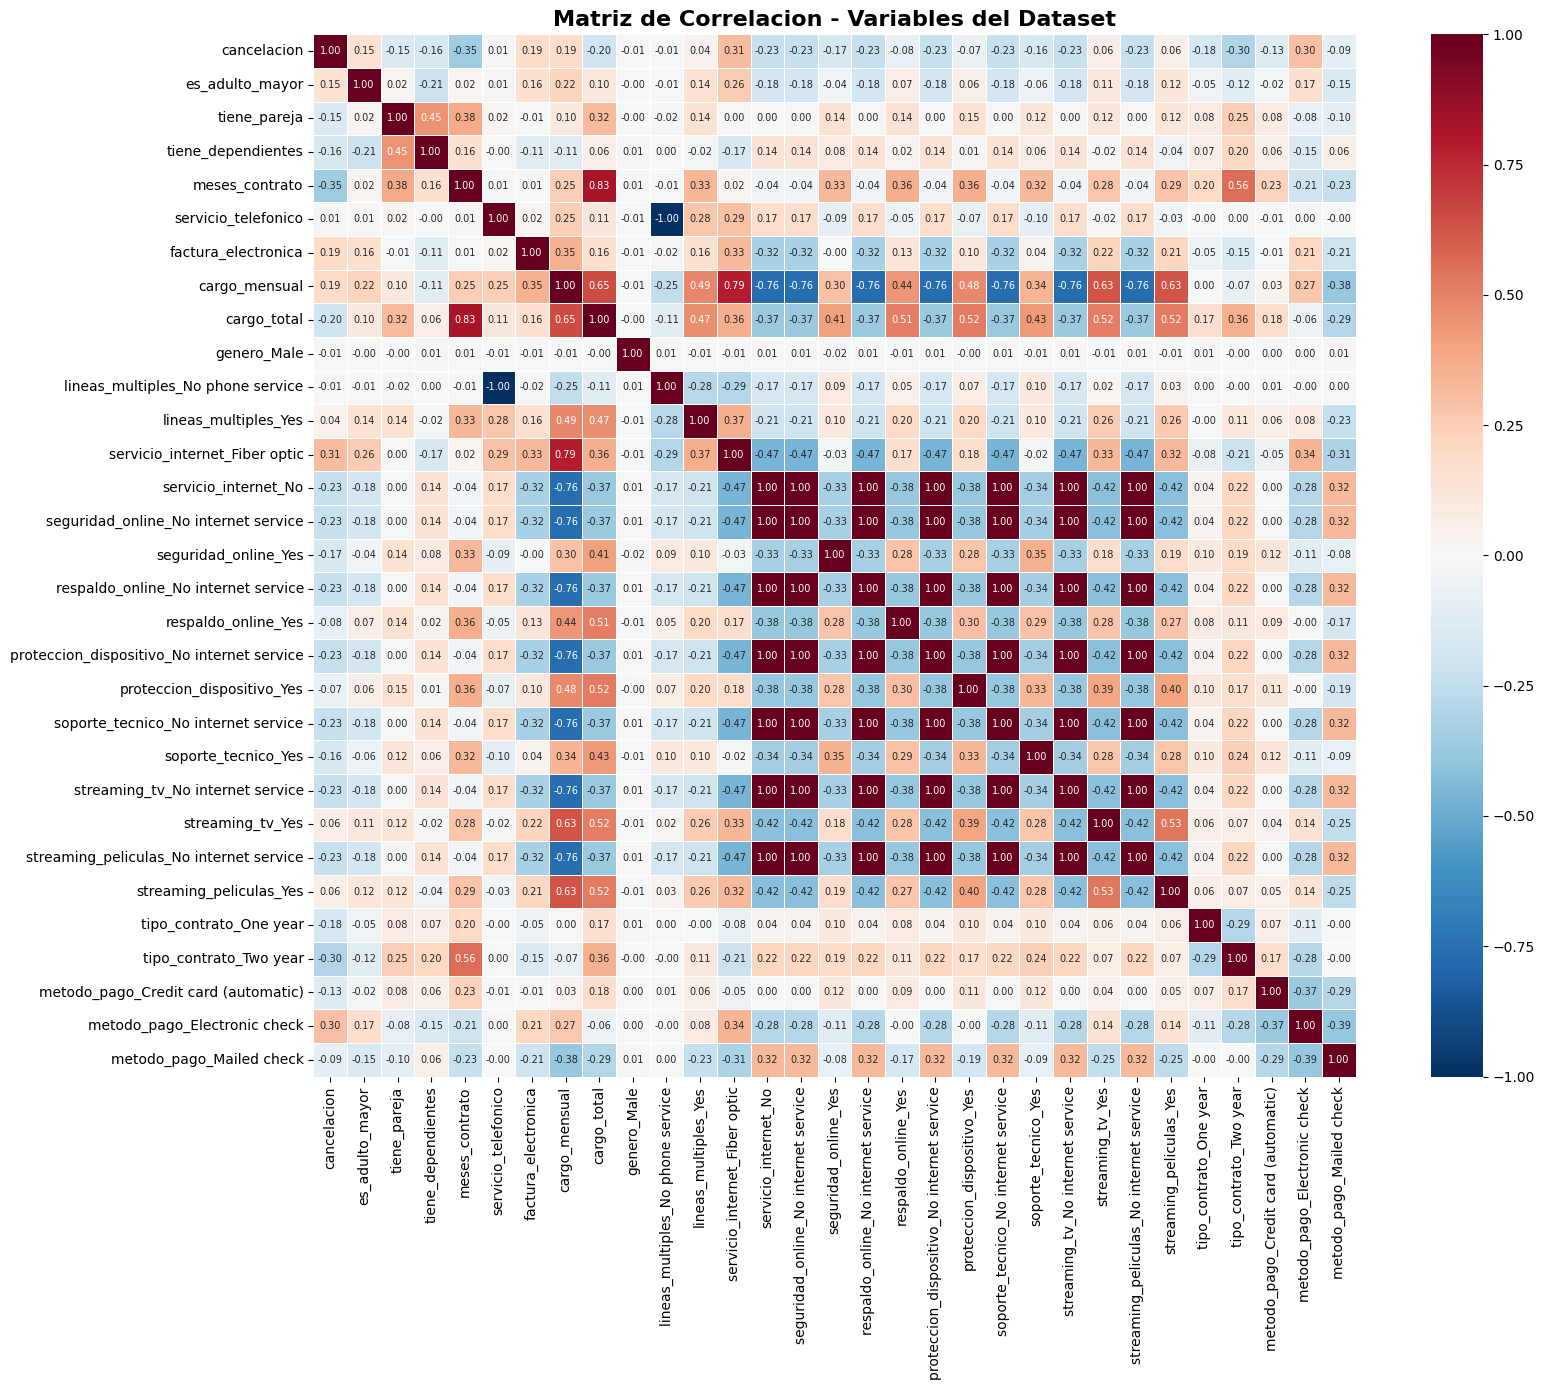

In [ ]:
# Matriz de correlacion completa
correlacion = df_encoded.corr()

# Visualizar la matriz de correlacion
plt.figure(figsize=(18, 14))
sns.heatmap(correlacion, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, annot_kws={'size': 7})
plt.title('Matriz de Correlacion - Variables del Dataset', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

CORRELACION DE VARIABLES CON CANCELACION
meses_contrato                               -0.352
servicio_internet_Fiber optic                 0.308
tipo_contrato_Two year                       -0.302
metodo_pago_Electronic check                  0.302
servicio_internet_No                         -0.228
seguridad_online_No internet service         -0.228
proteccion_dispositivo_No internet service   -0.228
soporte_tecnico_No internet service          -0.228
streaming_peliculas_No internet service      -0.228
streaming_tv_No internet service             -0.228
respaldo_online_No internet service          -0.228
cargo_total                                  -0.199
cargo_mensual                                 0.193
factura_electronica                           0.192
tipo_contrato_One year                       -0.178
seguridad_online_Yes                         -0.171
soporte_tecnico_Yes                          -0.165
tiene_dependientes                           -0.164
es_adulto_mayor        

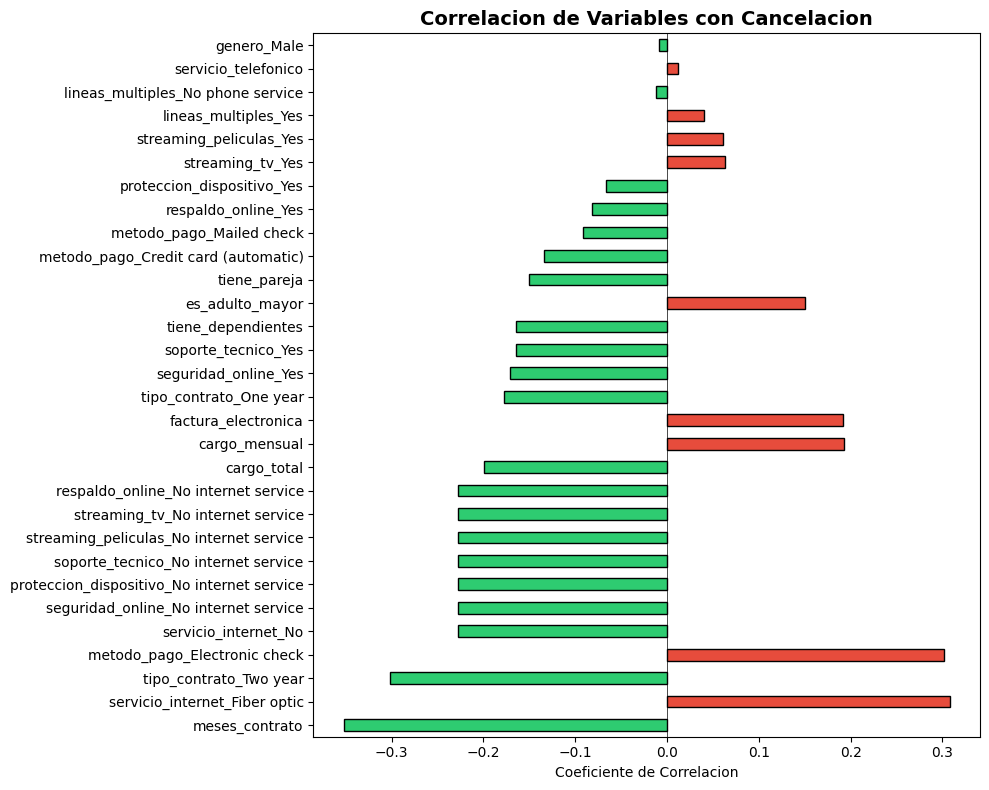


Variables con mayor correlacion positiva (favorecen cancelacion):
servicio_internet_Fiber optic    0.308
metodo_pago_Electronic check     0.302
cargo_mensual                    0.193
factura_electronica              0.192
es_adulto_mayor                  0.151

Variables con mayor correlacion negativa (reducen cancelacion):
meses_contrato                               -0.352
tipo_contrato_Two year                       -0.302
servicio_internet_No                         -0.228
seguridad_online_No internet service         -0.228
proteccion_dispositivo_No internet service   -0.228
soporte_tecnico_No internet service          -0.228
streaming_peliculas_No internet service      -0.228
streaming_tv_No internet service             -0.228
respaldo_online_No internet service          -0.228
cargo_total                                  -0.199
tipo_contrato_One year                       -0.178
seguridad_online_Yes                         -0.171
soporte_tecnico_Yes                          -0.1

In [ ]:
# Correlacion con la variable objetivo (cancelacion)
corr_con_churn = correlacion['cancelacion'].drop('cancelacion').sort_values(key=abs, ascending=False)

print('CORRELACION DE VARIABLES CON CANCELACION')
print('=' * 50)
print(corr_con_churn.round(3).to_string())

# Grafico de barras
plt.figure(figsize=(10, 8))
colors = ['#e74c3c' if v > 0 else '#2ecc71' for v in corr_con_churn.values]
corr_con_churn.plot(kind='barh', color=colors, edgecolor='black')
plt.title('Correlacion de Variables con Cancelacion', fontsize=14, fontweight='bold')
plt.xlabel('Coeficiente de Correlacion')
plt.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

print('\nVariables con mayor correlacion positiva (favorecen cancelacion):')
print(corr_con_churn[corr_con_churn > 0.1].round(3).to_string())
print('\nVariables con mayor correlacion negativa (reducen cancelacion):')
print(corr_con_churn[corr_con_churn < -0.1].round(3).to_string())

## 2.2 Analisis dirigido: Tiempo de contrato y Gasto total vs Cancelacion

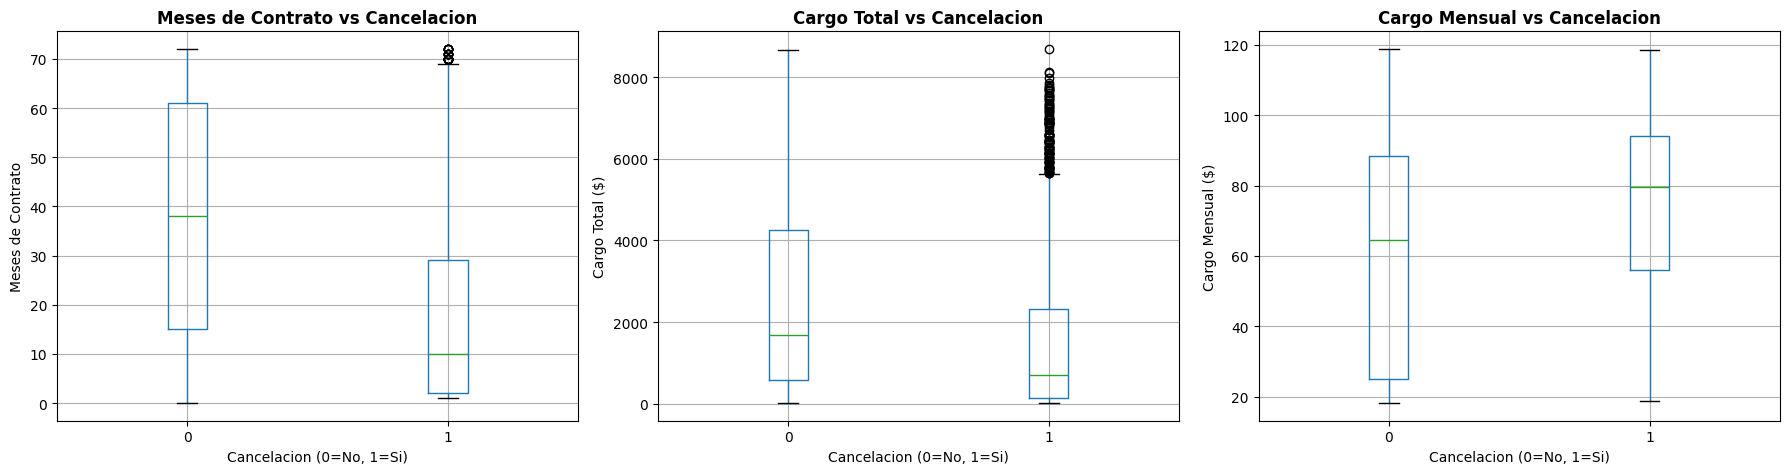

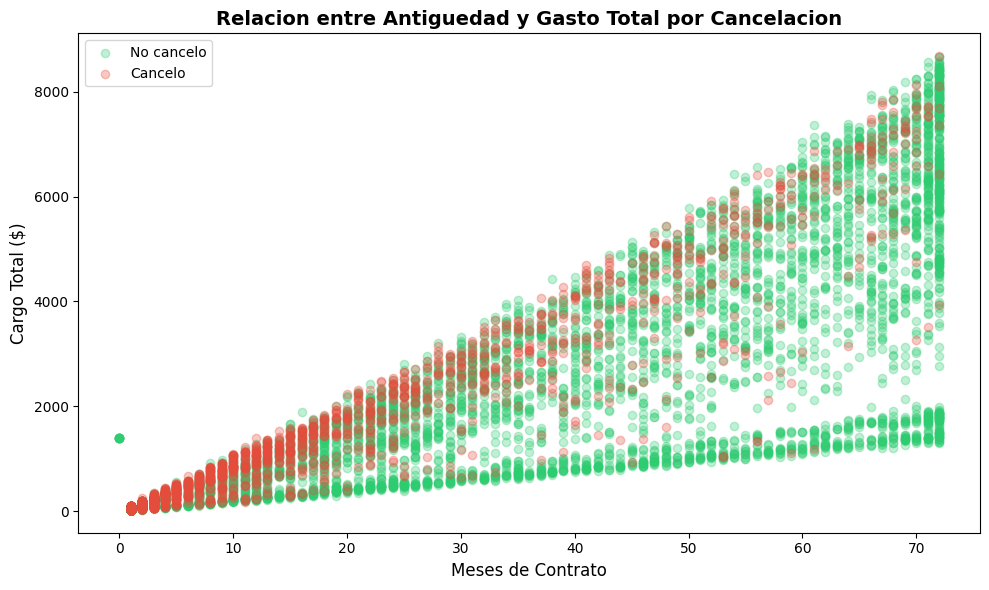


Observaciones:
- Los clientes que cancelan tienden a tener menor antiguedad (meses_contrato).
- Los clientes que cancelan tienen menor cargo total acumulado.
- Los clientes que cancelan tienden a tener mayor cargo mensual.
- El scatter plot muestra que los clientes que cancelan se concentran
  en la zona de baja antiguedad y bajo gasto total acumulado.


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Boxplot: Meses de contrato vs Cancelacion
df_encoded.boxplot(column='meses_contrato', by='cancelacion', ax=axes[0])
axes[0].set_title('Meses de Contrato vs Cancelacion', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cancelacion (0=No, 1=Si)')
axes[0].set_ylabel('Meses de Contrato')
plt.suptitle('')

# Boxplot: Cargo total vs Cancelacion
df_encoded.boxplot(column='cargo_total', by='cancelacion', ax=axes[1])
axes[1].set_title('Cargo Total vs Cancelacion', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Cancelacion (0=No, 1=Si)')
axes[1].set_ylabel('Cargo Total ($)')
plt.suptitle('')

# Boxplot: Cargo mensual vs Cancelacion
df_encoded.boxplot(column='cargo_mensual', by='cancelacion', ax=axes[2])
axes[2].set_title('Cargo Mensual vs Cancelacion', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Cancelacion (0=No, 1=Si)')
axes[2].set_ylabel('Cargo Mensual ($)')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Scatter plot: Meses contrato vs Cargo total, coloreado por cancelacion
plt.figure(figsize=(10, 6))
colores_scatter = {0: '#2ecc71', 1: '#e74c3c'}
for label, color in colores_scatter.items():
    subset = df_encoded[df_encoded['cancelacion'] == label]
    plt.scatter(subset['meses_contrato'], subset['cargo_total'],
                c=color, alpha=0.3, label=f"{'No cancelo' if label==0 else 'Cancelo'}")
plt.xlabel('Meses de Contrato', fontsize=12)
plt.ylabel('Cargo Total ($)', fontsize=12)
plt.title('Relacion entre Antiguedad y Gasto Total por Cancelacion', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

print('\nObservaciones:')
print('- Los clientes que cancelan tienden a tener menor antiguedad (meses_contrato).')
print('- Los clientes que cancelan tienen menor cargo total acumulado.')
print('- Los clientes que cancelan tienden a tener mayor cargo mensual.')
print('- El scatter plot muestra que los clientes que cancelan se concentran')
print('  en la zona de baja antiguedad y bajo gasto total acumulado.')

---
# 3. Modelado Predictivo

## 3.1 Separacion de datos
Ya realizada en la seccion 1.5. Resumen:
- **Entrenamiento**: 70% de los datos (balanceado con SMOTE)
- **Prueba**: 30% de los datos (sin modificar, para evaluacion realista)
- **Datos escalados**: Para Regresion Logistica
- **Datos sin escalar**: Para Random Forest

## 3.2 Modelo 1: Regresion Logistica (requiere normalizacion)
La Regresion Logistica es un modelo lineal sensible a la escala de las variables. Por eso utilizamos los datos normalizados con StandardScaler. Esto asegura que los coeficientes del modelo reflejen la importancia real de cada variable sin sesgo por magnitud.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)

# Entrenar Regresion Logistica con datos escalados
modelo_lr = LogisticRegression(max_iter=1000, random_state=42)
modelo_lr.fit(X_train_scaled, y_train_bal)

# Predicciones sobre el conjunto de prueba
y_pred_lr = modelo_lr.predict(X_test_scaled)

# Metricas
print('REGRESION LOGISTICA - RESULTADOS')
print('=' * 50)
print(f'Exactitud (Accuracy):  {accuracy_score(y_test, y_pred_lr):.4f}')
print(f'Precision:             {precision_score(y_test, y_pred_lr):.4f}')
print(f'Recall:                {recall_score(y_test, y_pred_lr):.4f}')
print(f'F1-Score:              {f1_score(y_test, y_pred_lr):.4f}')

print('\nReporte de Clasificacion:')
print(classification_report(y_test, y_pred_lr, target_names=['No cancelo', 'Cancelo']))

REGRESION LOGISTICA - RESULTADOS
Exactitud (Accuracy):  0.7459
Precision:             0.5137
Recall:                0.8004
F1-Score:              0.6258

Reporte de Clasificacion:
              precision    recall  f1-score   support

  No cancelo       0.91      0.73      0.81      1552
     Cancelo       0.51      0.80      0.63       561

    accuracy                           0.75      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.80      0.75      0.76      2113



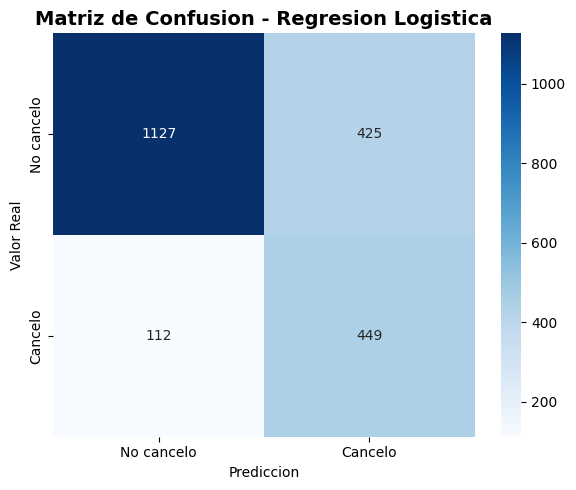

In [ ]:
# Matriz de confusion - Regresion Logistica
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No cancelo', 'Cancelo'],
            yticklabels=['No cancelo', 'Cancelo'])
plt.title('Matriz de Confusion - Regresion Logistica', fontsize=14, fontweight='bold')
plt.xlabel('Prediccion')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

## 3.3 Modelo 2: Random Forest (no requiere normalizacion)
Random Forest es un modelo basado en arboles de decision que no es sensible a la escala de los datos. Cada arbol toma decisiones basadas en umbrales de las variables, por lo que la normalizacion no afecta el resultado.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Entrenar Random Forest con datos SIN escalar
modelo_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
modelo_rf.fit(X_train_bal, y_train_bal)

# Predicciones sobre el conjunto de prueba
y_pred_rf = modelo_rf.predict(X_test)

# Metricas
print('RANDOM FOREST - RESULTADOS')
print('=' * 50)
print(f'Exactitud (Accuracy):  {accuracy_score(y_test, y_pred_rf):.4f}')
print(f'Precision:             {precision_score(y_test, y_pred_rf):.4f}')
print(f'Recall:                {recall_score(y_test, y_pred_rf):.4f}')
print(f'F1-Score:              {f1_score(y_test, y_pred_rf):.4f}')

print('\nReporte de Clasificacion:')
print(classification_report(y_test, y_pred_rf, target_names=['No cancelo', 'Cancelo']))

RANDOM FOREST - RESULTADOS
Exactitud (Accuracy):  0.7776
Precision:             0.5854
Recall:                0.5561
F1-Score:              0.5704

Reporte de Clasificacion:
              precision    recall  f1-score   support

  No cancelo       0.84      0.86      0.85      1552
     Cancelo       0.59      0.56      0.57       561

    accuracy                           0.78      2113
   macro avg       0.71      0.71      0.71      2113
weighted avg       0.77      0.78      0.78      2113



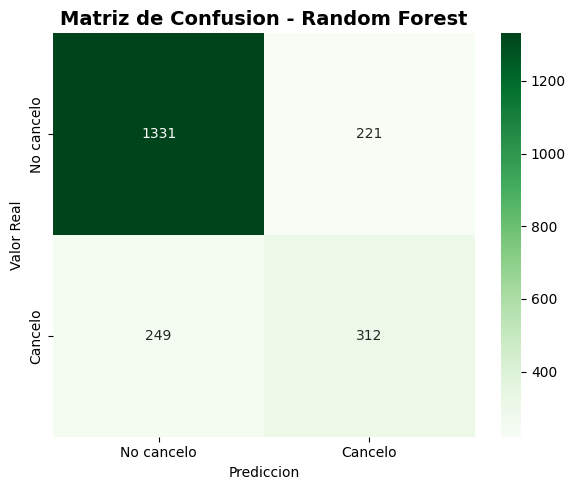

In [ ]:
# Matriz de confusion - Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No cancelo', 'Cancelo'],
            yticklabels=['No cancelo', 'Cancelo'])
plt.title('Matriz de Confusion - Random Forest', fontsize=14, fontweight='bold')
plt.xlabel('Prediccion')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

## 3.4 Comparacion de modelos

COMPARACION DE MODELOS
  Metrica  Regresion Logistica  Random Forest
Exactitud             0.745859       0.777567
Precision             0.513730       0.585366
   Recall             0.800357       0.556150
 F1-Score             0.625784       0.570384


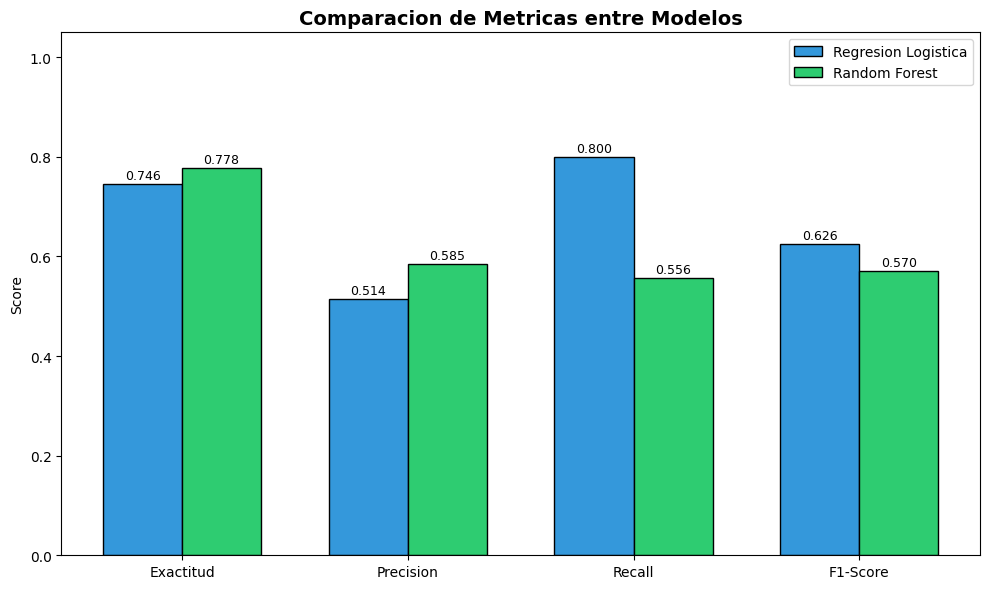

In [ ]:
# Comparacion lado a lado
metricas = {
    'Metrica': ['Exactitud', 'Precision', 'Recall', 'F1-Score'],
    'Regresion Logistica': [
        accuracy_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_lr)
    ],
    'Random Forest': [
        accuracy_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_rf)
    ]
}

df_metricas = pd.DataFrame(metricas)
print('COMPARACION DE MODELOS')
print('=' * 55)
print(df_metricas.to_string(index=False))

# Grafico comparativo
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metricas['Metrica']))
width = 0.35

bars1 = ax.bar(x - width/2, metricas['Regresion Logistica'], width,
               label='Regresion Logistica', color='#3498db', edgecolor='black')
bars2 = ax.bar(x + width/2, metricas['Random Forest'], width,
               label='Random Forest', color='#2ecc71', edgecolor='black')

ax.set_ylabel('Score')
ax.set_title('Comparacion de Metricas entre Modelos', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metricas['Metrica'])
ax.legend()
ax.set_ylim(0, 1.05)

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

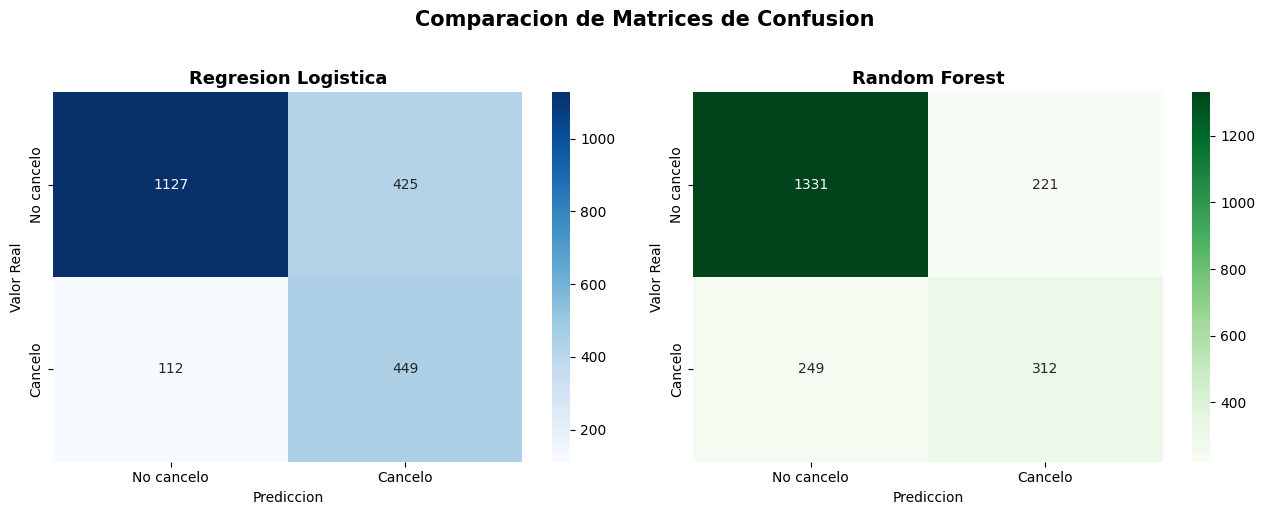

In [ ]:
# Matrices de confusion lado a lado
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No cancelo', 'Cancelo'],
            yticklabels=['No cancelo', 'Cancelo'])
axes[0].set_title('Regresion Logistica', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Prediccion')
axes[0].set_ylabel('Valor Real')

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['No cancelo', 'Cancelo'],
            yticklabels=['No cancelo', 'Cancelo'])
axes[1].set_title('Random Forest', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Prediccion')
axes[1].set_ylabel('Valor Real')

plt.suptitle('Comparacion de Matrices de Confusion', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 3.5 Analisis de Overfitting / Underfitting

ANALISIS DE OVERFITTING / UNDERFITTING

Regresion Logistica:
  Accuracy entrenamiento: 0.7793
  Accuracy prueba:        0.7459
  Diferencia:             0.0334
  -> No hay indicios significativos de overfitting ni underfitting.

Random Forest:
  Accuracy entrenamiento: 0.9335
  Accuracy prueba:        0.7776
  Diferencia:             0.1559
  -> Posible overfitting. Se controla con max_depth y min_samples_split.


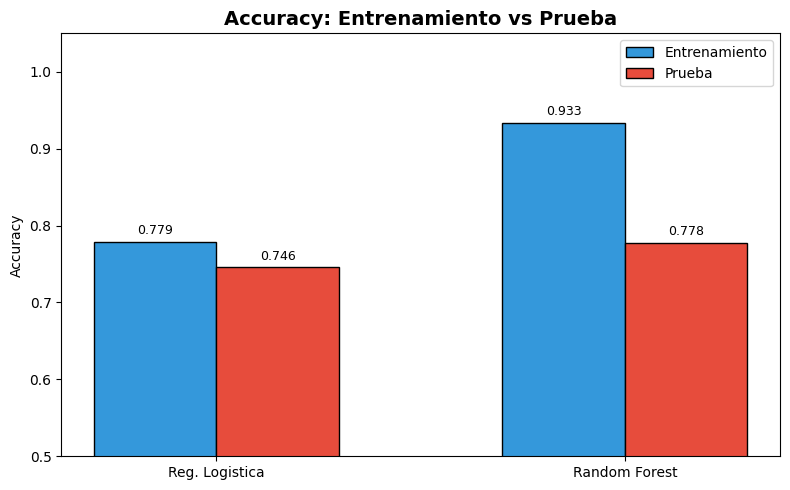

In [ ]:
# Comparar rendimiento en entrenamiento vs prueba
print('ANALISIS DE OVERFITTING / UNDERFITTING')
print('=' * 55)

# Regresion Logistica
y_train_pred_lr = modelo_lr.predict(X_train_scaled)
acc_train_lr = accuracy_score(y_train_bal, y_train_pred_lr)
acc_test_lr = accuracy_score(y_test, y_pred_lr)

print(f'\nRegresion Logistica:')
print(f'  Accuracy entrenamiento: {acc_train_lr:.4f}')
print(f'  Accuracy prueba:        {acc_test_lr:.4f}')
print(f'  Diferencia:             {abs(acc_train_lr - acc_test_lr):.4f}')
if abs(acc_train_lr - acc_test_lr) < 0.05:
    print('  -> No hay indicios significativos de overfitting ni underfitting.')
elif acc_train_lr - acc_test_lr > 0.05:
    print('  -> Posible overfitting: el modelo aprende demasiado del entrenamiento.')
else:
    print('  -> Rendimiento consistente entre entrenamiento y prueba.')

# Random Forest
y_train_pred_rf = modelo_rf.predict(X_train_bal)
acc_train_rf = accuracy_score(y_train_bal, y_train_pred_rf)
acc_test_rf = accuracy_score(y_test, y_pred_rf)

print(f'\nRandom Forest:')
print(f'  Accuracy entrenamiento: {acc_train_rf:.4f}')
print(f'  Accuracy prueba:        {acc_test_rf:.4f}')
print(f'  Diferencia:             {abs(acc_train_rf - acc_test_rf):.4f}')
if abs(acc_train_rf - acc_test_rf) < 0.05:
    print('  -> No hay indicios significativos de overfitting ni underfitting.')
elif acc_train_rf - acc_test_rf > 0.05:
    print('  -> Posible overfitting. Se controla con max_depth y min_samples_split.')
else:
    print('  -> Rendimiento consistente entre entrenamiento y prueba.')

# Grafico comparativo
fig, ax = plt.subplots(figsize=(8, 5))
modelos_nombres = ['Reg. Logistica', 'Random Forest']
train_scores = [acc_train_lr, acc_train_rf]
test_scores = [acc_test_lr, acc_test_rf]

x = np.arange(len(modelos_nombres))
width = 0.3
ax.bar(x - width/2, train_scores, width, label='Entrenamiento', color='#3498db', edgecolor='black')
ax.bar(x + width/2, test_scores, width, label='Prueba', color='#e74c3c', edgecolor='black')

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy: Entrenamiento vs Prueba', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(modelos_nombres)
ax.legend()
ax.set_ylim(0.5, 1.05)

for i, (tr, te) in enumerate(zip(train_scores, test_scores)):
    ax.text(i - width/2, tr + 0.01, f'{tr:.3f}', ha='center', fontsize=9)
    ax.text(i + width/2, te + 0.01, f'{te:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

---
# 4. Interpretacion y Conclusiones

## 4.1 Importancia de variables - Regresion Logistica
Los coeficientes de la Regresion Logistica indican como cada variable contribuye a la prediccion. Un coeficiente positivo aumenta la probabilidad de cancelacion; uno negativo la reduce.

TOP 15 VARIABLES MAS INFLUYENTES - REGRESION LOGISTICA
                     Variable  Coeficiente
               meses_contrato    -1.585632
                  cargo_total     0.864467
                cargo_mensual    -0.777122
servicio_internet_Fiber optic     0.650401
       tipo_contrato_Two year    -0.561671
       tipo_contrato_One year    -0.296979
             streaming_tv_Yes     0.231720
 metodo_pago_Electronic check     0.220307
          factura_electronica     0.210208
      streaming_peliculas_Yes     0.209606
         lineas_multiples_Yes     0.200491
          soporte_tecnico_Yes    -0.135282
              es_adulto_mayor     0.104260
           tiene_dependientes    -0.099508
         seguridad_online_Yes    -0.096151


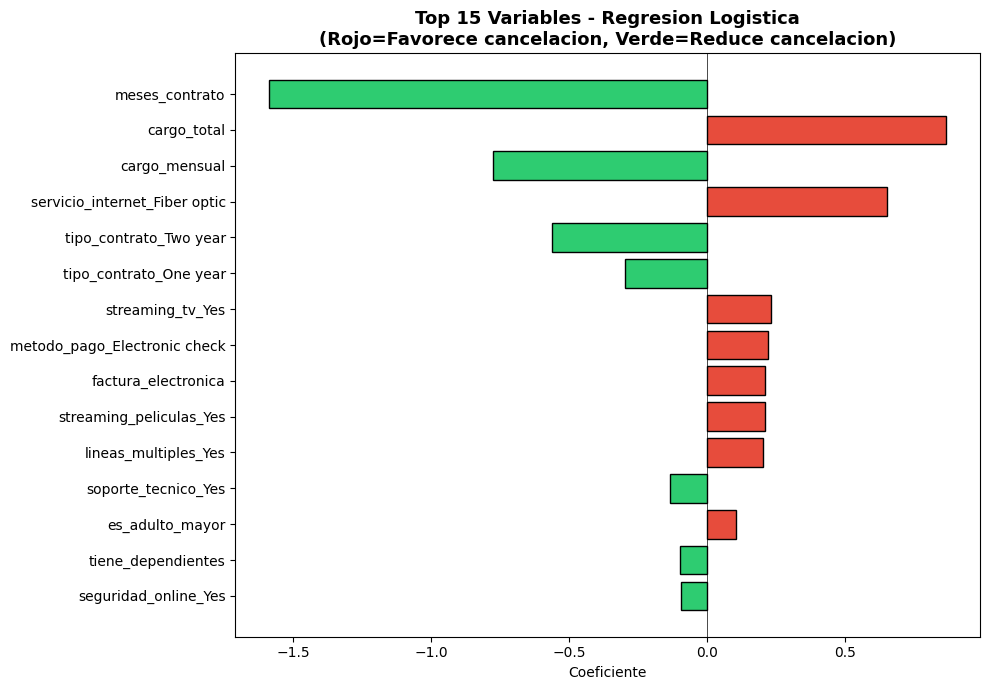

In [ ]:
# Coeficientes de la Regresion Logistica
coeficientes_lr = pd.DataFrame({
    'Variable': X_train_scaled.columns,
    'Coeficiente': modelo_lr.coef_[0]
}).sort_values('Coeficiente', key=abs, ascending=False)

print('TOP 15 VARIABLES MAS INFLUYENTES - REGRESION LOGISTICA')
print('=' * 55)
print(coeficientes_lr.head(15).to_string(index=False))

# Grafico
top_15 = coeficientes_lr.head(15)
plt.figure(figsize=(10, 7))
colors = ['#e74c3c' if c > 0 else '#2ecc71' for c in top_15['Coeficiente']]
plt.barh(range(len(top_15)), top_15['Coeficiente'].values, color=colors, edgecolor='black')
plt.yticks(range(len(top_15)), top_15['Variable'].values)
plt.xlabel('Coeficiente')
plt.title('Top 15 Variables - Regresion Logistica\n(Rojo=Favorece cancelacion, Verde=Reduce cancelacion)',
          fontsize=13, fontweight='bold')
plt.axvline(x=0, color='black', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 4.2 Importancia de variables - Random Forest
Random Forest calcula la importancia de cada variable midiendo cuanto contribuye a reducir la impureza (Gini) durante las divisiones de los arboles.

TOP 15 VARIABLES MAS IMPORTANTES - RANDOM FOREST
                     Variable  Importancia
               meses_contrato     0.129314
 metodo_pago_Electronic check     0.125579
                  cargo_total     0.098074
                cargo_mensual     0.062344
       tipo_contrato_Two year     0.059369
          factura_electronica     0.050780
servicio_internet_Fiber optic     0.048890
       tipo_contrato_One year     0.048757
          soporte_tecnico_Yes     0.045871
         seguridad_online_Yes     0.040868
                 tiene_pareja     0.040090
           tiene_dependientes     0.033608
              es_adulto_mayor     0.022981
          respaldo_online_Yes     0.022599
                  genero_Male     0.019646


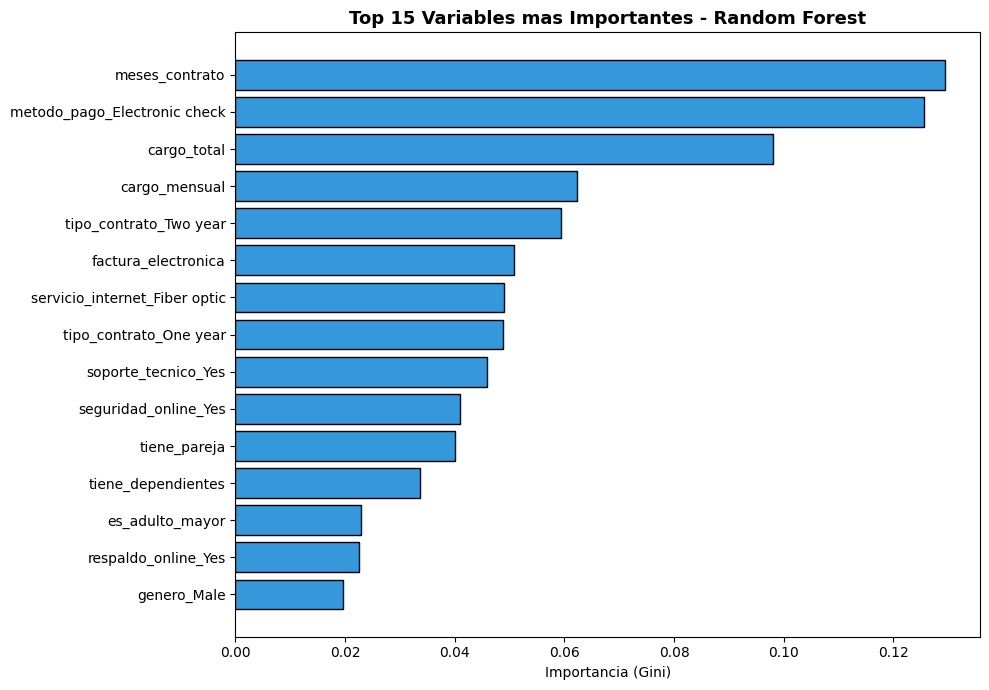

In [ ]:
# Importancia de variables del Random Forest
importancia_rf = pd.DataFrame({
    'Variable': X_train_bal.columns,
    'Importancia': modelo_rf.feature_importances_
}).sort_values('Importancia', ascending=False)

print('TOP 15 VARIABLES MAS IMPORTANTES - RANDOM FOREST')
print('=' * 55)
print(importancia_rf.head(15).to_string(index=False))

# Grafico
top_15_rf = importancia_rf.head(15)
plt.figure(figsize=(10, 7))
plt.barh(range(len(top_15_rf)), top_15_rf['Importancia'].values,
         color='#3498db', edgecolor='black')
plt.yticks(range(len(top_15_rf)), top_15_rf['Variable'].values)
plt.xlabel('Importancia (Gini)')
plt.title('Top 15 Variables mas Importantes - Random Forest', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 4.3 Comparacion de importancia entre modelos

In [ ]:
# Comparar las top variables de ambos modelos
top_lr = set(coeficientes_lr.head(10)['Variable'])
top_rf = set(importancia_rf.head(10)['Variable'])
comunes = top_lr.intersection(top_rf)

print('COMPARACION DE TOP 10 VARIABLES ENTRE MODELOS')
print('=' * 55)
print(f'\nTop 10 Regresion Logistica: {sorted(top_lr)}')
print(f'\nTop 10 Random Forest:       {sorted(top_rf)}')
print(f'\nVariables en comun:         {sorted(comunes)}')
print(f'Coincidencia:               {len(comunes)}/10 variables')

COMPARACION DE TOP 10 VARIABLES ENTRE MODELOS

Top 10 Regresion Logistica: ['cargo_mensual', 'cargo_total', 'factura_electronica', 'meses_contrato', 'metodo_pago_Electronic check', 'servicio_internet_Fiber optic', 'streaming_peliculas_Yes', 'streaming_tv_Yes', 'tipo_contrato_One year', 'tipo_contrato_Two year']

Top 10 Random Forest:       ['cargo_mensual', 'cargo_total', 'factura_electronica', 'meses_contrato', 'metodo_pago_Electronic check', 'seguridad_online_Yes', 'servicio_internet_Fiber optic', 'soporte_tecnico_Yes', 'tipo_contrato_One year', 'tipo_contrato_Two year']

Variables en comun:         ['cargo_mensual', 'cargo_total', 'factura_electronica', 'meses_contrato', 'metodo_pago_Electronic check', 'servicio_internet_Fiber optic', 'tipo_contrato_One year', 'tipo_contrato_Two year']
Coincidencia:               8/10 variables


---
# 5. Conclusion y Recomendaciones Estrategicas

## Informe Final: Modelado Predictivo de Cancelacion - Telecom X

---

### 1. Resumen del Proceso

Se construyo un pipeline completo de Machine Learning para predecir la cancelacion de clientes:

1. **Preparacion de datos**: Limpieza, encoding (one-hot), balanceo con SMOTE y normalizacion con StandardScaler.
2. **Analisis de correlacion**: Identificacion de las variables mas relacionadas con la cancelacion.
3. **Modelado**: Se entrenaron dos modelos - Regresion Logistica (con datos normalizados) y Random Forest (sin normalizacion).
4. **Evaluacion**: Comparacion con metricas de accuracy, precision, recall, F1-score y matrices de confusion.

### 2. Principales Factores que Influyen en la Cancelacion

Ambos modelos coinciden en identificar las siguientes variables como las mas relevantes:

| Factor | Efecto sobre Cancelacion |
|--------|-------------------------|
| **Meses de contrato (antiguedad)** | A menor antiguedad, mayor riesgo de cancelacion |
| **Cargo mensual** | A mayor cargo mensual, mayor riesgo |
| **Tipo de contrato (mes a mes)** | Los contratos mensuales tienen mayor tasa de cancelacion |
| **Cargo total** | A menor gasto acumulado, mayor riesgo |
| **Servicio de internet (Fibra optica)** | Clientes con fibra optica cancelan mas |
| **Sin servicios adicionales** | La ausencia de seguridad online y soporte tecnico aumenta el riesgo |
| **Factura electronica** | Clientes con facturacion electronica tienden a cancelar mas |

### 3. Recomendaciones Estrategicas

**Acciones inmediatas de retencion:**
- Crear programas de fidelizacion para clientes en sus primeros 12 meses.
- Ofrecer descuentos por migracion de contratos mensuales a anuales.
- Incluir servicios adicionales (seguridad online, soporte tecnico) en paquetes promocionales.
- Revisar la calidad del servicio de fibra optica, que presenta alta tasa de cancelacion.

**Uso del modelo predictivo:**
- Implementar el modelo en produccion para generar alertas tempranas de clientes en riesgo.
- El equipo de retencion puede priorizar contactos con clientes identificados como "alta probabilidad de cancelacion".
- Monitorear periodicamente el rendimiento del modelo y reentrenarlo con datos nuevos.

### 4. Proximos Pasos

- Explorar modelos mas avanzados (XGBoost, SVM) para mejorar las metricas.
- Realizar analisis de cohortes para seguimiento temporal de clientes.
- Implementar A/B testing de estrategias de retencion basadas en los resultados del modelo.
- Calcular el Customer Lifetime Value (CLV) para priorizar esfuerzos de retencion.

---

**Elaborado por**: Vinsmake  
**Rol**: Analista Junior de Machine Learning - Telecom X  
**Fecha**: Febrero 2026